In [1]:
# Tobechi Maduchukwu
# CSC 180
# Final Project
# 2 May 2022

# Data Preprocessing

In [2]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low



# Import data

In [3]:
import pandas as pd

players = pd.read_csv('data/nba-data.csv', sep=',')
players.drop('Tm', axis=1, inplace=True)
players.head()

,Rk,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa\achiupr01,PF,21,61,4,12.1,2.0,3.7,0.544,...,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0
1,2,Jaylen Adams\adamsja01,PG,24,7,0,2.6,0.1,1.1,0.125,...,NaN,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3
2,3,Steven Adams\adamsst01,C,27,58,58,27.7,3.3,5.3,0.614,...,0.444,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6
3,4,Bam Adebayo\adebaba01,C,23,64,64,33.5,7.1,12.5,0.570,...,0.799,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7
4,5,LaMarcus Aldridge\aldrila01,C,35,26,23,25.9,5.4,11.4,0.473,...,0.872,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5


## Drop duplicates

In [4]:
players = players.drop_duplicates(subset= ["Player"])
players[20:50]

,Rk,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
28,21,Deni Avdija\avdijde01,SF,20,54,32,23.3,2.4,5.8,0.417,...,0.644,0.4,4.4,4.9,1.2,0.6,0.3,0.6,2.6,6.3
29,22,Deandre Ayton\aytonde01,C,22,69,69,30.7,6.2,10.0,0.626,...,0.769,3.3,7.2,10.5,1.4,0.6,1.2,1.5,2.8,14.4
30,23,Udoka Azubuike\azubuud01,C,21,15,0,3.8,0.3,0.6,0.444,...,0.800,0.3,0.6,0.9,0.0,0.1,0.3,0.2,0.6,1.1
31,24,Dwayne Bacon\bacondw01,SG,25,72,50,25.7,4.1,10.1,0.402,...,0.824,0.4,2.7,3.1,1.3,0.6,0.1,0.6,1.4,10.9
32,25,Marvin Bagley III\baglema01,PF,21,43,42,25.9,5.7,11.4,0.504,...,0.575,2.5,4.9,7.4,1.0,0.5,0.5,1.4,2.3,14.1
33,26,LaMelo Ball\ballla01,PG,19,51,31,28.8,5.7,13.2,0.436,...,0.758,1.2,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7
34,27,Lonzo Ball\balllo01,PG,23,55,55,31.8,5.3,12.7,0.414,...,0.781,0.6,4.2,4.8,5.7,1.5,0.6,2.2,1.9,14.6
35,28,Mo Bamba\bambamo01,C,22,46,5,15.8,3.1,6.5,0.472,...,0.682,1.7,4.1,5.8,0.8,0.3,1.3,0.8,1.9,8.0
36,29,Desmond Bane\banede01,SG,22,68,17,22.3,3.4,7.3,0.469,...,0.816,0.5,2.6,3.1,1.7,0.6,0.2,0.9,1.8,9.2
37,30,Harrison Barnes\barneha02,PF,28,58,58,36.2,5.5,11.1,0.497,...,0.830,1.1,5.5,6.6,3.5,0.7,0.2,1.6,1.3,16.1


## Manually added AllStar data

In [5]:
# In essence, I am using encode_text_index()
players["AllStar"] = "NAS"
players.loc[players["Rk"]==38, "AllStar"] = "AS"
players.loc[players["Rk"]==244, "AllStar"] = "AS"
players.loc[players["Rk"]==12, "AllStar"] = "AS"
players.loc[players["Rk"]==140, "AllStar"] = "AS"
players.loc[players["Rk"]==146, "AllStar"] = "AS"
players.loc[players["Rk"]==74, "AllStar"] = "AS"
players.loc[players["Rk"]==201, "AllStar"] = "AS"
players.loc[players["Rk"]==286, "AllStar"] = "AS"
players.loc[players["Rk"]==457, "AllStar"] = "AS"
players.loc[players["Rk"]==421, "AllStar"] = "AS"
players.loc[players["Rk"]==444, "AllStar"] = "AS"
players.loc[players["Rk"]==473, "AllStar"] = "AS"
players.loc[players["Rk"]==504, "AllStar"] = "AS"
players.loc[players["Rk"]==116, "AllStar"] = "AS"
players.loc[players["Rk"]==130, "AllStar"] = "AS"
players.loc[players["Rk"]==252, "AllStar"] = "AS"
players.loc[players["Rk"]==293, "AllStar"] = "AS"
players.loc[players["Rk"]==263, "AllStar"] = "AS"
players.loc[players["Rk"]==58, "AllStar"] = "AS"
players.loc[players["Rk"]==106, "AllStar"] = "AS"
players.loc[players["Rk"]==297, "AllStar"] = "AS"
players.loc[players["Rk"]==348, "AllStar"] = "AS"
players.loc[players["Rk"]==396, "AllStar"] = "AS"
players.loc[players["Rk"]==118, "AllStar"] = "AS"
players.loc[players["Rk"]==174, "AllStar"] = "AS"
players.loc[players["Rk"]==528, "AllStar"] = "AS"
players.loc[players["Rk"]==180, "AllStar"] = "AS"
players[5:150]

,Rk,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AllStar
7,6,Ty-Shon Alexander\alexaty01,SG,22,15,0,3.1,0.2,0.8,0.250,...,0.1,0.5,0.7,0.4,0.0,0.1,0.2,0.1,0.6,NAS
8,7,Nickeil Alexander-Walker\alexani01,SG,22,46,13,21.9,4.2,10.0,0.419,...,0.3,2.8,3.1,2.2,1.0,0.5,1.5,1.9,11.0,NAS
9,8,Grayson Allen\allengr01,SG,25,50,38,25.2,3.5,8.3,0.418,...,0.4,2.8,3.2,2.2,0.9,0.2,1.0,1.4,10.6,NAS
10,9,Jarrett Allen\allenja01,C,22,63,45,29.6,4.7,7.7,0.618,...,3.1,6.9,10.0,1.7,0.5,1.4,1.6,1.5,12.8,NAS
13,10,Al-Farouq Aminu\aminual01,PF,30,23,14,18.9,1.7,4.3,0.384,...,1.0,3.8,4.8,1.3,0.8,0.4,1.2,1.3,4.4,NAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,146,Joel Embiid\embiijo01,C,26,51,51,31.1,9.0,17.6,0.513,...,2.2,8.4,10.6,2.8,1.0,1.4,3.1,2.4,28.5,AS
190,147,James Ennis III\ennisja01,SF,30,41,37,24.0,2.8,5.9,0.473,...,1.0,3.0,4.0,1.5,0.8,0.2,0.9,2.0,8.4,NAS
191,148,Drew Eubanks\eubandr01,C,23,54,3,14.0,2.1,3.8,0.566,...,1.4,3.1,4.5,0.8,0.3,0.9,0.8,1.6,5.8,NAS
192,149,Dante Exum\exumda01,SG,25,6,3,19.3,1.7,4.3,0.385,...,0.3,2.5,2.8,2.2,0.7,0.3,1.2,1.5,3.8,NAS


## Label Encoding

In [6]:
all_star = encode_text_index(players,"AllStar")
players

,Rk,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AllStar
0,1,Precious Achiuwa\achiupr01,PF,21,61,4,12.1,2.0,3.7,0.544,...,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,1
1,2,Jaylen Adams\adamsja01,PG,24,7,0,2.6,0.1,1.1,0.125,...,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3,1
2,3,Steven Adams\adamsst01,C,27,58,58,27.7,3.3,5.3,0.614,...,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6,1
3,4,Bam Adebayo\adebaba01,C,23,64,64,33.5,7.1,12.5,0.570,...,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7,1
4,5,LaMarcus Aldridge\aldrila01,C,35,26,23,25.9,5.4,11.4,0.473,...,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,536,Delon Wright\wrighde01,SG-PG,28,63,39,27.7,3.8,8.2,0.463,...,1.0,3.2,4.3,4.4,1.6,0.5,1.3,1.2,10.2,1
701,537,Thaddeus Young\youngth01,PF,32,68,23,24.3,5.4,9.7,0.559,...,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,1
702,538,Trae Young\youngtr01,PG,22,63,63,33.7,7.7,17.7,0.438,...,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,1
703,539,Cody Zeller\zelleco01,C,28,48,21,20.9,3.8,6.8,0.559,...,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,1


## One hot encoding on categorical features 

In [7]:
encode_text_dummy(players, "Pos")

players

,Rk,Player,Age,G,GS,MP,FG,FGA,FG%,3P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,1,Precious Achiuwa\achiupr01,21,61,4,12.1,2.0,3.7,0.544,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jaylen Adams\adamsja01,24,7,0,2.6,0.1,1.1,0.125,0.0,...,0,0,1,0,0,0,0,0,0,0
2,3,Steven Adams\adamsst01,27,58,58,27.7,3.3,5.3,0.614,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Bam Adebayo\adebaba01,23,64,64,33.5,7.1,12.5,0.570,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,LaMarcus Aldridge\aldrila01,35,26,23,25.9,5.4,11.4,0.473,1.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,536,Delon Wright\wrighde01,28,63,39,27.7,3.8,8.2,0.463,1.0,...,0,0,0,0,0,0,0,0,1,0
701,537,Thaddeus Young\youngth01,32,68,23,24.3,5.4,9.7,0.559,0.2,...,0,0,0,0,0,0,0,0,0,0
702,538,Trae Young\youngtr01,22,63,63,33.7,7.7,17.7,0.438,2.2,...,0,0,1,0,0,0,0,0,0,0
703,539,Cody Zeller\zelleco01,28,48,21,20.9,3.8,6.8,0.559,0.1,...,0,0,0,0,0,0,0,0,0,0


## Dropped Player, Rk, and Age columns

In [8]:
players.drop('Player', axis=1, inplace=True)
players.drop('Rk', axis=1, inplace=True)
players.drop('Age', axis=1, inplace=True)
players

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,2.6,0.1,1.1,0.125,0.0,0.3,0.000,0.1,...,0,0,1,0,0,0,0,0,0,0
2,58,58,27.7,3.3,5.3,0.614,0.0,0.1,0.000,3.3,...,0,0,0,0,0,0,0,0,0,0
3,64,64,33.5,7.1,12.5,0.570,0.0,0.1,0.250,7.1,...,0,0,0,0,0,0,0,0,0,0
4,26,23,25.9,5.4,11.4,0.473,1.2,3.1,0.388,4.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,63,39,27.7,3.8,8.2,0.463,1.0,2.7,0.372,2.8,...,0,0,0,0,0,0,0,0,1,0
701,68,23,24.3,5.4,9.7,0.559,0.2,0.7,0.267,5.3,...,0,0,0,0,0,0,0,0,0,0
702,63,63,33.7,7.7,17.7,0.438,2.2,6.3,0.343,5.6,...,0,0,1,0,0,0,0,0,0,0
703,48,21,20.9,3.8,6.8,0.559,0.1,0.6,0.143,3.7,...,0,0,0,0,0,0,0,0,0,0


## Resetting index

In [9]:
players = players.reset_index(drop=True)
players

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,2.6,0.1,1.1,0.125,0.0,0.3,0.000,0.1,...,0,0,1,0,0,0,0,0,0,0
2,58,58,27.7,3.3,5.3,0.614,0.0,0.1,0.000,3.3,...,0,0,0,0,0,0,0,0,0,0
3,64,64,33.5,7.1,12.5,0.570,0.0,0.1,0.250,7.1,...,0,0,0,0,0,0,0,0,0,0
4,26,23,25.9,5.4,11.4,0.473,1.2,3.1,0.388,4.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,63,39,27.7,3.8,8.2,0.463,1.0,2.7,0.372,2.8,...,0,0,0,0,0,0,0,0,1,0
536,68,23,24.3,5.4,9.7,0.559,0.2,0.7,0.267,5.3,...,0,0,0,0,0,0,0,0,0,0
537,63,63,33.7,7.7,17.7,0.438,2.2,6.3,0.343,5.6,...,0,0,1,0,0,0,0,0,0,0
538,48,21,20.9,3.8,6.8,0.559,0.1,0.6,0.143,3.7,...,0,0,0,0,0,0,0,0,0,0


## Encoding numeric values so the neural networks run well

In [10]:
encode_numeric_zscore(players, 'G')
encode_numeric_zscore(players, 'GS')
encode_numeric_zscore(players, 'MP')
encode_numeric_zscore(players, 'FG')
encode_numeric_zscore(players, 'FGA')
encode_numeric_zscore(players, 'FG%')
encode_numeric_zscore(players, '3P')
encode_numeric_zscore(players, '3PA')
encode_numeric_zscore(players, '3P%')
encode_numeric_zscore(players, '2P')
encode_numeric_zscore(players, '2PA')
encode_numeric_zscore(players, '2P%')
encode_numeric_zscore(players, 'eFG%')
encode_numeric_zscore(players, 'FT')
encode_numeric_zscore(players, 'FTA')
encode_numeric_zscore(players, 'FT%')
encode_numeric_zscore(players, 'ORB')
encode_numeric_zscore(players, 'DRB')
encode_numeric_zscore(players, 'TRB')
encode_numeric_zscore(players, 'AST')
encode_numeric_zscore(players, 'STL')
encode_numeric_zscore(players, 'BLK')
encode_numeric_zscore(players, 'TOV')
encode_numeric_zscore(players, 'PF')
encode_numeric_zscore(players, 'PTS')
players

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,0.884131,-0.690364,-0.829474,-0.549184,-0.716823,0.900040,-1.107935,-1.237042,-2.483014,-0.153581,...,0,0,0,0,0,0,0,0,0,0
1,-1.723724,-0.862955,-1.850078,-1.359340,-1.255073,-3.016149,-1.107935,-1.105208,-2.483014,-1.166267,...,0,0,1,0,0,0,0,0,0,0
2,0.739250,1.639614,0.846464,0.005133,-0.385592,1.554296,-1.107935,-1.193097,-2.483014,0.539310,...,0,0,0,0,0,0,0,0,0,0
3,1.029012,1.898501,1.469570,1.625444,1.104946,1.143049,-1.107935,-1.193097,-0.498985,2.564682,...,0,0,0,0,0,0,0,0,0,0
4,-0.806146,0.129443,0.653087,0.900568,0.877225,0.236437,0.218149,0.125242,0.596199,1.019003,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.980718,0.819807,0.846464,0.218331,0.214763,0.142972,-0.002865,-0.050536,0.469221,0.272813,...,0,0,0,0,0,0,0,0,1,0
536,1.222186,0.129443,0.481196,0.900568,0.525292,1.040237,-0.886921,-0.929429,-0.364071,1.605295,...,0,0,0,0,0,0,0,0,0,0
537,0.980718,1.855353,1.491056,1.881282,2.181446,-0.090691,1.323219,1.531471,0.239074,1.765193,...,0,0,1,0,0,0,0,0,0,0
538,0.256314,0.043148,0.115927,0.218331,-0.075064,1.040237,-0.997428,-0.973374,-1.348149,0.752507,...,0,0,0,0,0,0,0,0,0,0


## Dropping all rows with NA values

In [11]:
players = players.dropna()
players

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,0.884131,-0.690364,-0.829474,-0.549184,-0.716823,0.900040,-1.107935,-1.237042,-2.483014,-0.153581,...,0,0,0,0,0,0,0,0,0,0
2,0.739250,1.639614,0.846464,0.005133,-0.385592,1.554296,-1.107935,-1.193097,-2.483014,0.539310,...,0,0,0,0,0,0,0,0,0,0
3,1.029012,1.898501,1.469570,1.625444,1.104946,1.143049,-1.107935,-1.193097,-0.498985,2.564682,...,0,0,0,0,0,0,0,0,0,0
4,-0.806146,0.129443,0.653087,0.900568,0.877225,0.236437,0.218149,0.125242,0.596199,1.019003,...,0,0,0,0,0,0,0,0,0,0
5,-1.337375,-0.862955,-1.796362,-1.316700,-1.317179,-1.847835,-0.997428,-0.973374,-0.721196,-1.166267,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.980718,0.819807,0.846464,0.218331,0.214763,0.142972,-0.002865,-0.050536,0.469221,0.272813,...,0,0,0,0,0,0,0,0,1,0
536,1.222186,0.129443,0.481196,0.900568,0.525292,1.040237,-0.886921,-0.929429,-0.364071,1.605295,...,0,0,0,0,0,0,0,0,0,0
537,0.980718,1.855353,1.491056,1.881282,2.181446,-0.090691,1.323219,1.531471,0.239074,1.765193,...,0,0,1,0,0,0,0,0,0,0
538,0.256314,0.043148,0.115927,0.218331,-0.075064,1.040237,-0.997428,-0.973374,-1.348149,0.752507,...,0,0,0,0,0,0,0,0,0,0


In [12]:
players = players.reset_index(drop=True)
players

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,0.884131,-0.690364,-0.829474,-0.549184,-0.716823,0.900040,-1.107935,-1.237042,-2.483014,-0.153581,...,0,0,0,0,0,0,0,0,0,0
1,0.739250,1.639614,0.846464,0.005133,-0.385592,1.554296,-1.107935,-1.193097,-2.483014,0.539310,...,0,0,0,0,0,0,0,0,0,0
2,1.029012,1.898501,1.469570,1.625444,1.104946,1.143049,-1.107935,-1.193097,-0.498985,2.564682,...,0,0,0,0,0,0,0,0,0,0
3,-0.806146,0.129443,0.653087,0.900568,0.877225,0.236437,0.218149,0.125242,0.596199,1.019003,...,0,0,0,0,0,0,0,0,0,0
4,-1.337375,-0.862955,-1.796362,-1.316700,-1.317179,-1.847835,-0.997428,-0.973374,-0.721196,-1.166267,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.980718,0.819807,0.846464,0.218331,0.214763,0.142972,-0.002865,-0.050536,0.469221,0.272813,...,0,0,0,0,0,0,0,0,1,0
499,1.222186,0.129443,0.481196,0.900568,0.525292,1.040237,-0.886921,-0.929429,-0.364071,1.605295,...,0,0,0,0,0,0,0,0,0,0
500,0.980718,1.855353,1.491056,1.881282,2.181446,-0.090691,1.323219,1.531471,0.239074,1.765193,...,0,0,1,0,0,0,0,0,0,0
501,0.256314,0.043148,0.115927,0.218331,-0.075064,1.040237,-0.997428,-0.973374,-1.348149,0.752507,...,0,0,0,0,0,0,0,0,0,0


# Seperate data into train and test

In [13]:
from sklearn.model_selection import train_test_split
x,y = to_xy(players, 'AllStar')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
y.shape


(503, 2)

In [14]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(metrics.classification_report(y_true, pred))

0
Epoch 1/100


2022-05-11 13:40:29.323414: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


12/12 - 1s - loss: 0.9293 - val_loss: 0.8981 - 801ms/epoch - 67ms/step
Epoch 2/100
12/12 - 0s - loss: 0.7752 - val_loss: 0.7457 - 56ms/epoch - 5ms/step
Epoch 3/100
12/12 - 0s - loss: 0.6602 - val_loss: 0.6304 - 68ms/epoch - 6ms/step
Epoch 4/100
12/12 - 0s - loss: 0.5775 - val_loss: 0.5403 - 55ms/epoch - 5ms/step
Epoch 5/100
12/12 - 0s - loss: 0.5139 - val_loss: 0.4735 - 90ms/epoch - 7ms/step
Epoch 6/100
12/12 - 0s - loss: 0.4643 - val_loss: 0.4198 - 82ms/epoch - 7ms/step
Epoch 7/100
12/12 - 0s - loss: 0.4214 - val_loss: 0.3746 - 75ms/epoch - 6ms/step
Epoch 8/100
12/12 - 0s - loss: 0.3829 - val_loss: 0.3358 - 76ms/epoch - 6ms/step
Epoch 9/100
12/12 - 0s - loss: 0.3485 - val_loss: 0.3027 - 71ms/epoch - 6ms/step
Epoch 10/100
12/12 - 0s - loss: 0.3167 - val_loss: 0.2738 - 62ms/epoch - 5ms/step
Epoch 11/100
12/12 - 0s - loss: 0.2886 - val_loss: 0.2488 - 69ms/epoch - 6ms/step
Epoch 12/100
12/12 - 0s - loss: 0.2636 - val_loss: 0.2274 - 96ms/epoch - 8ms/step
Epoch 13/100
12/12 - 0s - loss: 0.2

## Display the data

In [15]:
pred = model.predict(x_test)
print(pred[0:5]) # print first five predictions

[[4.3066326e-03 9.9569339e-01]
 [8.1709732e-04 9.9918288e-01]
 [9.5224887e-04 9.9904770e-01]
 [4.5555177e-01 5.4444814e-01]
 [3.4480793e-03 9.9655187e-01]]


In [16]:
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Plot confusion matrix

[[  3   1]
 [  1 121]]
Plotting confusion matrix


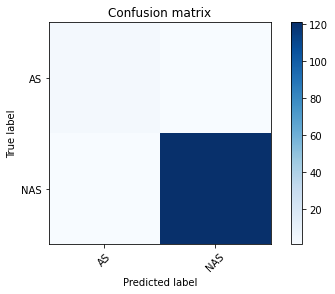

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.99      0.99      0.99       122

    accuracy                           0.98       126
   macro avg       0.87      0.87      0.87       126
weighted avg       0.98      0.98      0.98       126



In [18]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, all_star)
plt.show()

print(classification_report(y_true, pred))

## Plot ROC curve

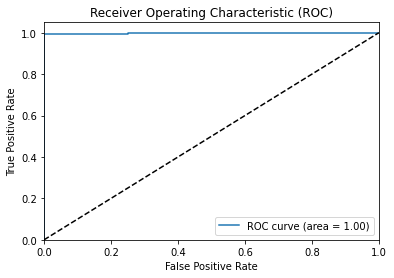

In [19]:
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

In [20]:
# Generate predictions
pred = model.predict(x_test)

print("Numpy array of predictions")
print(pred[0:5])
print()
print("y_test:")
print(y_test[0:5])

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

Numpy array of predictions
[[4.3066326e-03 9.9569339e-01]
 [8.1709732e-04 9.9918288e-01]
 [9.5224887e-04 9.9904770e-01]
 [4.5555177e-01 5.4444814e-01]
 [3.4480793e-03 9.9655187e-01]]

y_test:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Log loss score: 0.04037757476656149


# Logistic Regression Algorithm

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(players, players["AllStar"], test_size=0.25, random_state=0)
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print(score)

0.9920634920634921


[[  0   4]
 [  4 118]]
Plotting confusion matrix


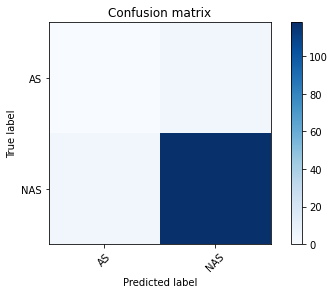

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.97      0.97      0.97       122

    accuracy                           0.94       126
   macro avg       0.48      0.48      0.48       126
weighted avg       0.94      0.94      0.94       126



In [22]:
cm = confusion_matrix(y_true, predictions)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, all_star)
plt.show()

print(classification_report(y_true, predictions))

# K-Nearest Neighbors Algorithm

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train, y_train)
print("train shape: " + str(x_train.shape))
print("score on test: " + str(knn.score(x_test, y_test)))
print("score on train: "+ str(knn.score(x_train, y_train)))
predictions = knn.predict(x_test)

train shape: (377, 39)
score on test: 0.9920634920634921
score on train: 0.9761273209549072


# Support Vector Machine Algorithm

In [24]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(x_train, y_train)
print("score on test: " + str(svm.score(x_test, y_test)))
print("score on train: "+ str(svm.score(x_train, y_train)))

score on test: 0.9761904761904762
score on train: 0.9442970822281167


# Decision Tree Algorithm

In [25]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
print("score on test: "  + str(clf.score(x_test, y_test)))
print("score on train: " + str(clf.score(x_train, y_train)))

score on test: 1.0
score on train: 1.0


# Boosted Decision Tree Algorithm

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(x_train, y_train)
print("score on test: " + str(adb.score(x_test, y_test)))
print("score on train: "+ str(adb.score(x_train, y_train)))


score on test: 1.0
score on train: 1.0


# Fully Connected Neural Network Redo

In [27]:
yoo = encode_text_index(players, "AllStar")
x,y = to_xy(players, "AllStar")
players

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos-PF-C,Pos-PF-SF,Pos-PG,Pos-PG-SG,Pos-SF,Pos-SF-PF,Pos-SF-SG,Pos-SG,Pos-SG-PG,Pos-SG-SF
0,0.884131,-0.690364,-0.829474,-0.549184,-0.716823,0.900040,-1.107935,-1.237042,-2.483014,-0.153581,...,0,0,0,0,0,0,0,0,0,0
1,0.739250,1.639614,0.846464,0.005133,-0.385592,1.554296,-1.107935,-1.193097,-2.483014,0.539310,...,0,0,0,0,0,0,0,0,0,0
2,1.029012,1.898501,1.469570,1.625444,1.104946,1.143049,-1.107935,-1.193097,-0.498985,2.564682,...,0,0,0,0,0,0,0,0,0,0
3,-0.806146,0.129443,0.653087,0.900568,0.877225,0.236437,0.218149,0.125242,0.596199,1.019003,...,0,0,0,0,0,0,0,0,0,0
4,-1.337375,-0.862955,-1.796362,-1.316700,-1.317179,-1.847835,-0.997428,-0.973374,-0.721196,-1.166267,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.980718,0.819807,0.846464,0.218331,0.214763,0.142972,-0.002865,-0.050536,0.469221,0.272813,...,0,0,0,0,0,0,0,0,1,0
499,1.222186,0.129443,0.481196,0.900568,0.525292,1.040237,-0.886921,-0.929429,-0.364071,1.605295,...,0,0,0,0,0,0,0,0,0,0
500,0.980718,1.855353,1.491056,1.881282,2.181446,-0.090691,1.323219,1.531471,0.239074,1.765193,...,0,0,1,0,0,0,0,0,0,0
501,0.256314,0.043148,0.115927,0.218331,-0.075064,1.040237,-0.997428,-0.973374,-1.348149,0.752507,...,0,0,0,0,0,0,0,0,0,0


In [28]:
x.shape

(503, 38)

In [29]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [30]:
model = Sequential()

model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1], activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit(x,y,verbose=2,epochs=100)


Epoch 1/100
16/16 - 0s - loss: 0.5188 - 360ms/epoch - 23ms/step
Epoch 2/100
16/16 - 0s - loss: 0.2873 - 32ms/epoch - 2ms/step
Epoch 3/100
16/16 - 0s - loss: 0.2038 - 52ms/epoch - 3ms/step
Epoch 4/100
16/16 - 0s - loss: 0.1587 - 49ms/epoch - 3ms/step
Epoch 5/100
16/16 - 0s - loss: 0.1300 - 54ms/epoch - 3ms/step
Epoch 6/100
16/16 - 0s - loss: 0.1129 - 39ms/epoch - 2ms/step
Epoch 7/100
16/16 - 0s - loss: 0.1001 - 51ms/epoch - 3ms/step
Epoch 8/100
16/16 - 0s - loss: 0.0914 - 31ms/epoch - 2ms/step
Epoch 9/100
16/16 - 0s - loss: 0.0826 - 36ms/epoch - 2ms/step
Epoch 10/100
16/16 - 0s - loss: 0.0769 - 48ms/epoch - 3ms/step
Epoch 11/100
16/16 - 0s - loss: 0.0721 - 39ms/epoch - 2ms/step
Epoch 12/100
16/16 - 0s - loss: 0.0650 - 46ms/epoch - 3ms/step
Epoch 13/100
16/16 - 0s - loss: 0.0624 - 38ms/epoch - 2ms/step
Epoch 14/100
16/16 - 0s - loss: 0.0592 - 36ms/epoch - 2ms/step
Epoch 15/100
16/16 - 0s - loss: 0.0552 - 32ms/epoch - 2ms/step
Epoch 16/100
16/16 - 0s - loss: 0.0511 - 28ms/epoch - 2ms/step

In [31]:
print(yoo)

[0 1]


In [32]:
pred = model.predict(x)
pred.shape

(503, 2)

In [33]:
pred

array([[2.8336458e-09, 1.0000000e+00],
       [9.2627499e-07, 9.9999905e-01],
       [1.8174050e-02, 9.8182595e-01],
       ...,
       [9.8686758e-04, 9.9901307e-01],
       [2.3999744e-06, 9.9999762e-01],
       [4.2762935e-07, 9.9999952e-01]], dtype=float32)

In [34]:
print(y)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [35]:
predict_classes = np.argmax(pred,axis=1)

true_classes = np.argmax(y,axis=1)

print("Predictions: {}".format(predict_classes))
print("True: {}".format(true_classes))

Predictions: [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1

In [36]:
print(yoo[predict_classes[80:259]])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [37]:
correct = metrics.accuracy_score(true_classes, predict_classes)
print("Accuracy: {}".format(correct))

Accuracy: 1.0


# Repeating but without normalizing data

In [38]:
import pandas as pd

players2 = pd.read_csv('data/nba-data.csv', sep=',')
players2 = players2.drop_duplicates(subset= ["Player"])
players2.drop('Tm', axis=1, inplace=True)

players2.drop('Player', axis=1, inplace=True)
players2.drop('Pos', axis=1, inplace=True)
players2.drop('Age', axis=1, inplace=True)

players2 = players2.dropna()
players2 = players2.reset_index(drop=True)
players2.head()

,Rk,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,...,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0
1,3,58,58,27.7,3.3,5.3,0.614,0.0,0.1,0.000,...,0.444,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6
2,4,64,64,33.5,7.1,12.5,0.570,0.0,0.1,0.250,...,0.799,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7
3,5,26,23,25.9,5.4,11.4,0.473,1.2,3.1,0.388,...,0.872,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5
4,6,15,0,3.1,0.2,0.8,0.250,0.1,0.6,0.222,...,0.500,0.1,0.5,0.7,0.4,0.0,0.1,0.2,0.1,0.6


In [39]:
players2["AllStar"] = "NAS"
players2.loc[players2["Rk"]==38, "AllStar"] = "AS"
players2.loc[players2["Rk"]==244, "AllStar"] = "AS"
players2.loc[players2["Rk"]==12, "AllStar"] = "AS"
players2.loc[players2["Rk"]==140, "AllStar"] = "AS"
players2.loc[players2["Rk"]==146, "AllStar"] = "AS"
players2.loc[players2["Rk"]==74, "AllStar"] = "AS"
players2.loc[players2["Rk"]==201, "AllStar"] = "AS"
players2.loc[players2["Rk"]==286, "AllStar"] = "AS"
players2.loc[players2["Rk"]==457, "AllStar"] = "AS"
players2.loc[players2["Rk"]==421, "AllStar"] = "AS"
players2.loc[players2["Rk"]==444, "AllStar"] = "AS"
players2.loc[players2["Rk"]==473, "AllStar"] = "AS"
players2.loc[players2["Rk"]==504, "AllStar"] = "AS"
players2.loc[players2["Rk"]==116, "AllStar"] = "AS"
players2.loc[players2["Rk"]==130, "AllStar"] = "AS"
players2.loc[players2["Rk"]==252, "AllStar"] = "AS"
players2.loc[players2["Rk"]==293, "AllStar"] = "AS"
players2.loc[players2["Rk"]==263, "AllStar"] = "AS"
players2.loc[players2["Rk"]==58, "AllStar"] = "AS"
players2.loc[players2["Rk"]==106, "AllStar"] = "AS"
players2.loc[players2["Rk"]==297, "AllStar"] = "AS"
players2.loc[players2["Rk"]==348, "AllStar"] = "AS"
players2.loc[players2["Rk"]==396, "AllStar"] = "AS"
players2.loc[players2["Rk"]==118, "AllStar"] = "AS"
players2.loc[players2["Rk"]==174, "AllStar"] = "AS"
players2.loc[players2["Rk"]==528, "AllStar"] = "AS"
players2.loc[players2["Rk"]==180, "AllStar"] = "AS"
players2.head()

,Rk,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AllStar
0,1,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,...,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,NAS
1,3,58,58,27.7,3.3,5.3,0.614,0.0,0.1,0.000,...,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6,NAS
2,4,64,64,33.5,7.1,12.5,0.570,0.0,0.1,0.250,...,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7,NAS
3,5,26,23,25.9,5.4,11.4,0.473,1.2,3.1,0.388,...,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5,NAS
4,6,15,0,3.1,0.2,0.8,0.250,0.1,0.6,0.222,...,0.1,0.5,0.7,0.4,0.0,0.1,0.2,0.1,0.6,NAS


In [40]:
players2.drop('Rk', axis=1, inplace=True)
all_star = encode_text_index(players2,"AllStar")
players2.head()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AllStar
0,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,...,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,1
1,58,58,27.7,3.3,5.3,0.614,0.0,0.1,0.000,3.3,...,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6,1
2,64,64,33.5,7.1,12.5,0.570,0.0,0.1,0.250,7.1,...,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7,1
3,26,23,25.9,5.4,11.4,0.473,1.2,3.1,0.388,4.2,...,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5,1
4,15,0,3.1,0.2,0.8,0.250,0.1,0.6,0.222,0.1,...,0.1,0.5,0.7,0.4,0.0,0.1,0.2,0.1,0.6,1


In [41]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(players2)

      G  GS    MP    FG   FGA    FG%   3P   3PA    3P%    2P   2PA    2P%  \
0    61   4  12.1   2.0   3.7  0.544  0.0   0.0  0.000   2.0   3.7  0.546   
1    58  58  27.7   3.3   5.3  0.614  0.0   0.1  0.000   3.3   5.3  0.620   
2    64  64  33.5   7.1  12.5  0.570  0.0   0.1  0.250   7.1  12.4  0.573   
3    26  23  25.9   5.4  11.4  0.473  1.2   3.1  0.388   4.2   8.3  0.505   
4    15   0   3.1   0.2   0.8  0.250  0.1   0.6  0.222   0.1   0.2  0.333   
5    46  13  21.9   4.2  10.0  0.419  1.7   4.8  0.347   2.5   5.2  0.485   
6    50  38  25.2   3.5   8.3  0.418  2.1   5.5  0.391   1.3   2.8  0.471   
7    63  45  29.6   4.7   7.7  0.618  0.1   0.3  0.316   4.6   7.3  0.631   
8    23  14  18.9   1.7   4.3  0.384  0.3   1.6  0.216   1.3   2.7  0.484   
9    69  69  27.3   4.5   9.5  0.468  1.4   3.8  0.360   3.1   5.8  0.539   
10   61  61  33.0  10.3  18.0  0.569  1.1   3.6  0.303   9.2  14.4  0.636   
11   57   3   9.7   1.2   2.4  0.489  0.1   0.5  0.241   1.1   1.9  0.556   

In [42]:
x,y = to_xy(players2, "AllStar")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
x.shape
players2

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AllStar
0,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,3.7,0.546,0.544,0.9,1.8,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,1
1,58,58,27.7,3.3,5.3,0.614,0.0,0.1,0.000,3.3,5.3,0.620,0.614,1.0,2.3,0.444,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6,1
2,64,64,33.5,7.1,12.5,0.570,0.0,0.1,0.250,7.1,12.4,0.573,0.571,4.4,5.5,0.799,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7,1
3,26,23,25.9,5.4,11.4,0.473,1.2,3.1,0.388,4.2,8.3,0.505,0.525,1.6,1.8,0.872,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5,1
4,15,0,3.1,0.2,0.8,0.250,0.1,0.6,0.222,0.1,0.2,0.333,0.333,0.1,0.1,0.500,0.1,0.5,0.7,0.4,0.0,0.1,0.2,0.1,0.6,1
5,46,13,21.9,4.2,10.0,0.419,1.7,4.8,0.347,2.5,5.2,0.485,0.502,1.0,1.4,0.727,0.3,2.8,3.1,2.2,1.0,0.5,1.5,1.9,11.0,1
6,50,38,25.2,3.5,8.3,0.418,2.1,5.5,0.391,1.3,2.8,0.471,0.547,1.6,1.8,0.868,0.4,2.8,3.2,2.2,0.9,0.2,1.0,1.4,10.6,1
7,63,45,29.6,4.7,7.7,0.618,0.1,0.3,0.316,4.6,7.3,0.631,0.624,3.2,4.6,0.703,3.1,6.9,10.0,1.7,0.5,1.4,1.6,1.5,12.8,1
8,23,14,18.9,1.7,4.3,0.384,0.3,1.6,0.216,1.3,2.7,0.484,0.424,0.8,1.0,0.818,1.0,3.8,4.8,1.3,0.8,0.4,1.2,1.3,4.4,1
9,69,69,27.3,4.5,9.5,0.468,1.4,3.8,0.360,3.1,5.8,0.539,0.540,2.1,2.7,0.783,0.8,5.0,5.7,3.6,1.2,0.8,1.2,1.7,12.4,1


In [43]:
y
y.shape

(503, 2)

In [44]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))
print('Training finished...Loading the best model')  
print()

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(metrics.classification_report(y_true, pred))

0
Epoch 1/100


/Users/tobechi/.local/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 - 1s - loss: 6.6722 - val_loss: 3.5208 - 1s/epoch - 88ms/step
Epoch 2/100
12/12 - 0s - loss: 2.0632 - val_loss: 0.4925 - 160ms/epoch - 13ms/step
Epoch 3/100
12/12 - 0s - loss: 0.3809 - val_loss: 0.2370 - 103ms/epoch - 9ms/step
Epoch 4/100
12/12 - 0s - loss: 0.4537 - val_loss: 0.2273 - 117ms/epoch - 10ms/step
Epoch 5/100
12/12 - 0s - loss: 0.3606 - val_loss: 0.1626 - 142ms/epoch - 12ms/step
Epoch 6/100
12/12 - 0s - loss: 0.2682 - val_loss: 0.1721 - 67ms/epoch - 6ms/step
Epoch 7/100
12/12 - 0s - loss: 0.2707 - val_loss: 0.1665 - 58ms/epoch - 5ms/step
Epoch 8/100
12/12 - 0s - loss: 0.2452 - val_loss: 0.1407 - 83ms/epoch - 7ms/step
Epoch 9/100
12/12 - 0s - loss: 0.2387 - val_loss: 0.1330 - 71ms/epoch - 6ms/step
Epoch 10/100
12/12 - 0s - loss: 0.2283 - val_loss: 0.1293 - 85ms/epoch - 7ms/step
Epoch 11/100
12/12 - 0s - loss: 0.2257 - val_loss: 0.1285 - 71ms/epoch - 6ms/step
Epoch 12/100
12/12 - 0s - loss: 0.2122 - val_loss: 0.1175 - 72ms/epoch - 6ms/step
Epoch 13/100
12/12 - 0s - loss:

[[  2   2]
 [  0 122]]
Plotting confusion matrix


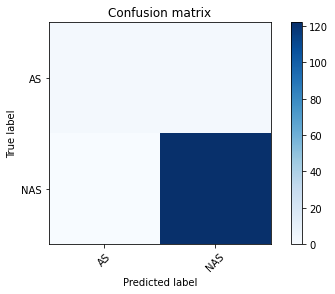

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.98      1.00      0.99       122

    accuracy                           0.98       126
   macro avg       0.99      0.75      0.83       126
weighted avg       0.98      0.98      0.98       126



In [45]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, all_star)
plt.show()

print(classification_report(y_true, pred))

In [67]:
sample_player = np.array( [[61,61,33.0,10.3,18.0,.569,1.1,3.6,.303,9.2,14.4,.636,.600,6.5,9.5,.685,1.6,9.4,11.0,5.9,1.2,1.2,3.4,2.8,28.1]], dtype=float)
pred = model.predict(sample_player)
print(pred)

[[0.8808051  0.11919491]]


In [68]:
pred = np.argmax(pred, axis=1)
print("Predict that Giannis Antetokounmpo {} is: {}".format(sample_player,all_star[pred]))

Predict that Giannis Antetokounmpo [[61.    61.    33.    10.3   18.     0.569  1.1    3.6    0.303  9.2
  14.4    0.636  0.6    6.5    9.5    0.685  1.6    9.4   11.     5.9
   1.2    1.2    3.4    2.8   28.1  ]] is: ['AS']


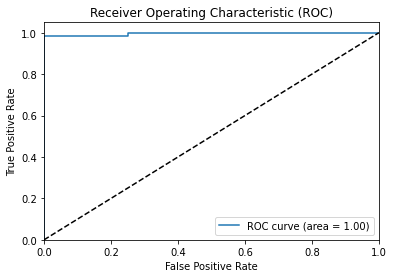

In [49]:
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

In [50]:
sample_player = np.array( [[68,14,21.4,3.3,6.0,.553,0.3,0.9,.333,3.0,5.1,.592,.578,0.9,1.4,.696,2.3,4.3,6.7,0.9,0.6,1.3,1.0,2.7,7.9]], dtype=float)
pred = model.predict(sample_player)
print(pred)

[[6.785932e-07 9.999993e-01]]


In [51]:
pred = np.argmax(pred, axis=1)
print("Predict that Isaiah Stewart {} is: {}".format(sample_player,all_star[pred]))

Predict that Isaiah Stewart [[68.    14.    21.4    3.3    6.     0.553  0.3    0.9    0.333  3.
   5.1    0.592  0.578  0.9    1.4    0.696  2.3    4.3    6.7    0.9
   0.6    1.3    1.     2.7    7.9  ]] is: ['NAS']


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train, y_train)
print("train shape: " + str(x_train.shape))
print("score on test: " + str(knn.score(x_test, y_test)))
print("score on train: "+ str(knn.score(x_train, y_train)))
predictions = knn.predict(x_test)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(players, players["AllStar"], test_size=0.25, random_state=0)
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print(score)

# A minor attempt to implement a CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(3, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
y_train.shape, y_test.shape

In [ ]:
model.fit(x_train[0:600], y_train[0:600],     
          batch_size=128,
          epochs=10,
          verbose=2,
          validation_data=(x_test[0:100], y_test[0:100]))

In [ ]:
score = model.evaluate(x_test[0:100], y_test[0:100], verbose=0)
score

In [ ]:
from sklearn import metrics

y_true = np.argmax(y_test[0:500],axis=1)
pred = model.predict(x_test[0:500])
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train, y_train)
print("train shape: " + str(x_train.shape))
print("score on test: " + str(knn.score(x_test, y_test)))
print("score on train: "+ str(knn.score(x_train, y_train)))
predictions = knn.predict(x_test)